<center>
    
    COMP4240/5435 - Reinforcement Learning
    
# Homework 6 - On-policy Control with Approximation

    
</center>

Student Name: _____Harshal Dafade_____

**General Notes:**
- Questions marked with * are optional for COMP4240 - Undergraduate section. Questions marked as extra credit are optional for everyone. 
- Do not use a mix of python lists and numpy arrays. Every vector or matrix in your code should be a numpy array. 
- For functions that exist in both the python core and the numpy library, use the one in the numpy library. For example, use `np.max` instead of `max`. Another example: use `np.random.normal` instead of `random.gauss`.
- Make sure all of your plots have a proper size and include `xlabel`, `ylabel`, `legend`, `title`, and `grid`.

The purpose of this project is to study different properties of Function Approximation with on-policy control methods.  

In [1]:
# You are allowed to use the following modules
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym

## Task description
Consider the task of driving an underpowered car up a steep mountain road, as suggested by the diagram in the upper left of the following figure. The difficulty is that gravity is stronger than the car's engine, and even at full throttle the car cannot accelerate up the steep slope. The only solution is to first move away from the goal and up the opposite slope on the left. Then by applying full throttle the car can build up enough inertia to carry it up the steep slope even though it is slowing down the whole way.


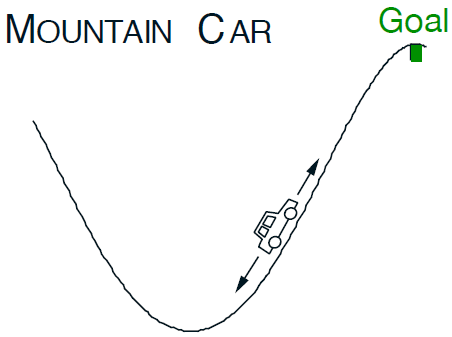


This is a continuous control task where things have to get worse in a sense (farther from the goal) before they can get better. 

**Observation space**

The observation is two dimensional including the position of the car along the x-axis and velocity of the car.

**Action space**

There are three deterministic actions: 0 accelerate to the left, 1 do nothing, and 2 accelerate to the right.

**Transition dynamics**

The car moves according to a simplified physics. Its position $x_t$ and velocity $\dot{x}_t$ are updated by

$x_{t+1} \doteq \text{bound}[x_t + \dot{x}_{t+1}]$

$\dot{x}_{t+1} \doteq \text{bound}[\dot{x}_t + 0.001 (A_t-1) - 0.0025 \cos(3x_t)]$


where the \textit{bound} operation enforces $-1.2 \le x_{t+1} \le 0.6$ and $-0.07 \le \dot{x}_{t+1} \le 0.07$. In addition, when $x_{t+1}$ reached the left bound, $\dot{x}_{t+1}$ was reset to zero. When it reached the right bound, the goal was reached and the episode was terminated. 

**Reward**

The reward in this problem is -1 on all time steps until the car moves past its goal position at the top of the mountain, which ends the episode. 

**Initial State**

Each episode starts from a random position $x_t \in [-0.6, -0.4)$ and zero velocity.

**Goal and Termination**

The episode terminates when the position of the car is greater than or equal to 0.5 (the goal position on top of the right hill).

**Arguments**

> env = gym.make('MountainCar-v0')

**Note**

Do not use the Continuous Mountain Car environment for this homework.
> gym.make('MountainCarContinuous-v0')


## Part I (4 points)

Check and confirm that the given Mountain Car simulation works as expected. Make sure you can observe and log (if needed) all the observations, actions, rewards, and termination conditions. You can animate the simulation by adding `render_mode='human'` when calling the `gym.make` class.  


In [2]:
import gymnasium as gym
import numpy as np

env = gym.make('MountainCar-v0', render_mode='human')
observation, info = env.reset()
step=0
done = False
while not done:
    action = env.action_space.sample()
    next_observation, reward, done, truncated, info = env.step(action)
    step+=1
    print(step)
    print(f"Observation: {observation}, Action: {action}, Reward: {reward}, Done: {done}")
    observation = next_observation
    if step == 50 : done = True
env.close()

1
Observation: [-0.58803695  0.        ], Action: 1, Reward: -1.0, Done: False
2
Observation: [-5.8755666e-01  4.8028197e-04], Action: 0, Reward: -1.0, Done: False
3
Observation: [-5.8759964e-01 -4.2971576e-05], Action: 1, Reward: -1.0, Done: False
4
Observation: [-5.8716559e-01  4.3409126e-04], Action: 0, Reward: -1.0, Done: False
5
Observation: [-5.8725762e-01 -9.2042195e-05], Action: 0, Reward: -1.0, Done: False
6
Observation: [-0.5878751 -0.0006175], Action: 1, Reward: -1.0, Done: False
7
Observation: [-5.8801353e-01 -1.3840728e-04], Action: 0, Reward: -1.0, Done: False
8
Observation: [-0.5886718 -0.0006583], Action: 1, Reward: -1.0, Done: False
9
Observation: [-5.8884513e-01 -1.7334422e-04], Action: 1, Reward: -1.0, Done: False
10
Observation: [-5.8853227e-01  3.1288483e-04], Action: 1, Reward: -1.0, Done: False
11
Observation: [-0.5877355   0.00079681], Action: 2, Reward: -1.0, Done: False
12
Observation: [-0.5854606   0.00227487], Action: 1, Reward: -1.0, Done: False
13
Observat

## Part II (6 points)

In this part, you will practice writing code for approximating the state value function. 

(a) write a function that generates Fourier basis features for a problem with one continuous state (1D state). The output of this function should be a vector of Fourier basis functions,
$X(s) = [\cos(0 * \pi * s), ..., \cos(n * \pi * s)]$ where $n$ represents the approximation order.

(b) Write a function that given a state $S$ and a weight vector $w$ calculates $V(S, w)$ by multiplying $w$ and $X(S)$. Make sure this is a vector-vector multiplication (dot product in this case) and avoid using for loops. Test your function with different values of $w$ and $S$. 

(c) Does $S$ need to be bounded? If yes, how would you do that? Write a function that given state in its original range returns bounded state.




In [3]:
# part II.a --- Your code here ---
import numpy as np

def generate_Fourier_features(s,n):
    indices = np.arange(n+1)
    return np.cos(indices * np.pi * s)




In [4]:
# part II.c --- Your answer here ---

def bound(s, lower_bound, upper_bound):
    return(s-lower_bound) / (upper_bound - lower_bound)



In [5]:
# part II.b --- Your code here ---
def get_state_value(s,n):
    pos, vel = s
    bound_pos = bound(pos, -1.2, 0.6)
    bound_vel = bound(vel,-0.07, 0.07)
    position_feature = generate_Fourier_features(bound_pos,n )
    velocity_feature = generate_Fourier_features(bound_vel, n)
    return np.concatenate([position_feature, velocity_feature])



## Part III (40 points)

Implement the **Episodic Semi-gradient SARSA** (pp. 244).

In [6]:
import numpy as np

def n_step_semi_gradient_sarsa(env, order, alpha, gamma, epsilon, num_episodes, n):
    num_actions = env.action_space.n
    weights = np.zeros(((order + 1) * 2, num_actions))
    episode_rewards = []
    episode_steps = []
    max_steps = 1000

    def evaluate_q_value(state, action, weights, degree):
        features = get_state_value(state, degree)
        return np.dot(weights[:, action], features)

    def select_action(state, weights, epsilon, num_actions, degree):
        if np.random.rand() < epsilon:
            return env.action_space.sample() 
        else:
            q_vals = [evaluate_q_value(state, a, weights, degree) for a in range(num_actions)]
            max_q = np.max(q_vals)
            best_actions = [a for a in range(num_actions) if q_vals[a] == max_q]
            return np.random.choice(best_actions) 

    def perform_weight_update(buffer, T, t, step_count, gamma, weights, alpha, degree):
        tau = t - step_count + 1  
        if tau >= 0:  
            G = 0
            for i in range(tau + 1, min(tau + step_count + 1, T + 1)):
                G += (gamma ** (i - tau - 1)) * buffer[i][2]  
            if tau + step_count < T:  
                next_state, next_action = buffer[tau + step_count][:2]
                G += (gamma ** step_count) * evaluate_q_value(next_state, next_action, weights, degree)

            current_state, current_action = buffer[tau][:2]
            features = get_state_value(current_state, degree)
            td_error = G - evaluate_q_value(current_state, current_action, weights, degree)
            weights[:, current_action] += alpha * td_error * features  

    for episode in range(num_episodes):
        epsilon = max(0.01, epsilon * 0.99) 
        state, _ = env.reset()
        action = select_action(state, weights, epsilon, num_actions, order)

        trajectory = [(state, action, 0)] 
        t, T = 0, float("inf")
        total_reward = 0

        while True:
            if t < T:
                next_state, reward, done, _, _ = env.step(action)
                total_reward += reward
                next_action = select_action(next_state, weights, epsilon, num_actions, order) if not done else None
                trajectory.append((next_state, next_action, reward))

                if done:
                    T = t + 1

                state, action = next_state, next_action

            perform_weight_update(trajectory, T, t, n, gamma, weights, alpha, order)
            t += 1

            if t >= T or t >= max_steps:
                break

        episode_rewards.append(total_reward)
        episode_steps.append(t)

    return episode_steps, episode_rewards, weights


## Part IV (50 points) 

(a) Use the algorithm to learn the Mountain Car task. Tune the step-size parameter ($\alpha$), select a proper Function Approximation order, discount factor ($\gamma$), exploration probability ($\varepsilon$). 


(b) Plot sum of reward-per-episode vs. number of episodes. This plot should be averaged over 50-100 runs.


(c) Plot step-per-episode (in log scale) vs. number of episodes. This plot should be averaged over 50-100 runs.

(d) Animate the last episode in a selected run. Does the approximated policy seem optimal? Why?

Run 1/50
Run 2/50
Run 3/50
Run 4/50
Run 5/50
Run 6/50
Run 7/50
Run 8/50
Run 9/50
Run 10/50
Run 11/50
Run 12/50
Run 13/50
Run 14/50
Run 15/50
Run 16/50
Run 17/50
Run 18/50
Run 19/50
Run 20/50
Run 21/50
Run 22/50
Run 23/50
Run 24/50
Run 25/50
Run 26/50
Run 27/50
Run 28/50
Run 29/50
Run 30/50
Run 31/50
Run 32/50
Run 33/50
Run 34/50
Run 35/50
Run 36/50
Run 37/50
Run 38/50
Run 39/50
Run 40/50
Run 41/50
Run 42/50
Run 43/50
Run 44/50
Run 45/50
Run 46/50
Run 47/50
Run 48/50
Run 49/50
Run 50/50


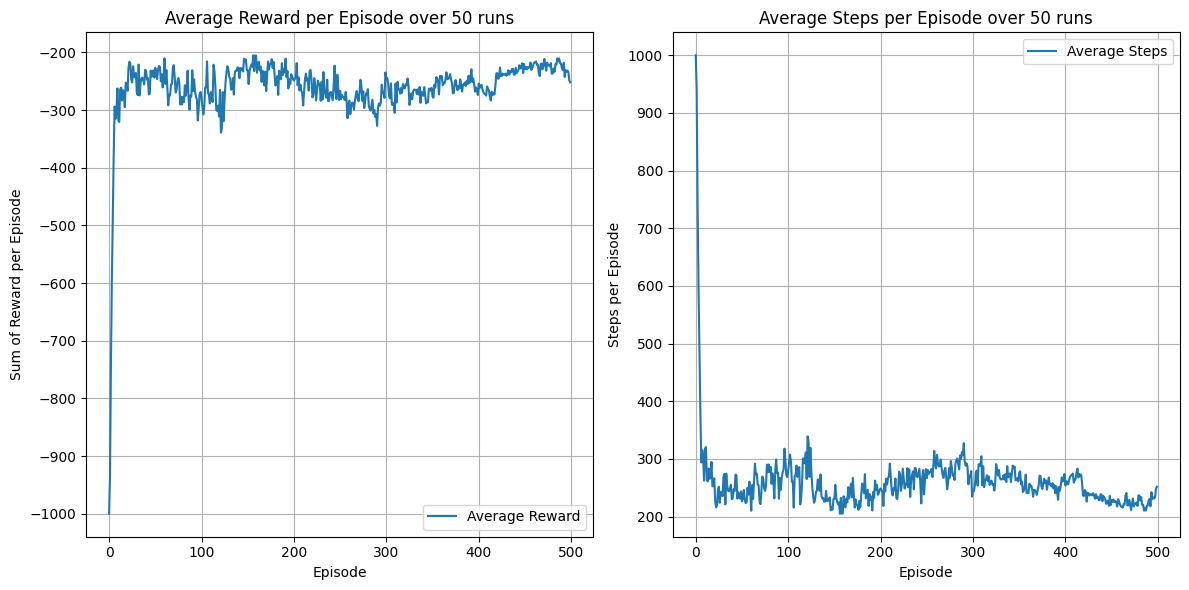

Animating the last episode...
Last Episode: Total Steps = 157, Total Reward = -157.0


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym

def average_performance_over_runs(env_name, order, alpha, gamma, epsilon, num_episodes, n, num_runs):
    env = gym.make(env_name)
    all_rewards = np.zeros((num_runs, num_episodes))  
    all_steps = np.zeros((num_runs, num_episodes))   

    for run in range(num_runs):
        print(f"Run {run + 1}/{num_runs}")
        steps, rewards, _ = n_step_semi_gradient_sarsa(env, order, alpha, gamma, epsilon, num_episodes, n)
        all_rewards[run] = rewards
        all_steps[run] = steps

    avg_rewards = np.mean(all_rewards, axis=0)
    avg_steps = np.mean(all_steps, axis=0)
    return avg_rewards, avg_steps


def animate_last_episode(env_name, weights, order, num_actions):
    env = gym.make(env_name, render_mode="human")
    env.metadata["render_fps"] = 100

    def evaluate_q_value(state, action, weights, degree):
        features = get_state_value(state, degree)
        return np.dot(weights[:, action], features)

    def select_best_action(state, weights, num_actions, degree):
        q_vals = [evaluate_q_value(state, a, weights, degree) for a in range(num_actions)]
        max_q = np.max(q_vals)
        best_actions = [a for a in range(num_actions) if q_vals[a] == max_q]
        return np.random.choice(best_actions)

    state, _ = env.reset()
    done = False
    total_steps = 0
    total_reward = 0

    while not done:
        action = select_best_action(state, weights, num_actions, order)
        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward
        total_steps += 1
        env.render()
        state = next_state

    print(f"Last Episode: Total Steps = {total_steps}, Total Reward = {total_reward}")
    env.close()

if __name__ == "__main__":
    ENV_NAME = "MountainCar-v0"
    order = 5
    alpha = 0.01
    gamma = 0.99
    epsilon = 0.1
    num_episodes = 500
    n = 1
    num_runs = 50

    avg_rewards, avg_steps = average_performance_over_runs(
        ENV_NAME, order, alpha, gamma, epsilon, num_episodes, n, num_runs
    )

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(avg_rewards, label="Average Reward")
    plt.xlabel("Episode")
    plt.ylabel("Sum of Reward per Episode")
    plt.title(f"Average Reward per Episode over {num_runs} runs")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot((avg_steps), label="Average Steps")
    plt.xlabel("Episode")
    plt.ylabel("Steps per Episode")
    plt.title(f"Average Steps per Episode over {num_runs} runs")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print("Animating the last episode...")
    env = gym.make(ENV_NAME)
    _, _, weights = n_step_semi_gradient_sarsa(env, order, alpha, gamma, epsilon, num_episodes, n)
    animate_last_episode(ENV_NAME, weights, order, env.action_space.n)


## Part V (20 Extra Points)

(a) Implement the **Episodic Semi-gradient $n$-step SARSA** (pp. 247).

In [13]:
# Your code here
import numpy as np

def n_step_semi_gradient_sarsa(env, order, alpha, gamma, epsilon, num_episodes, n):
    num_actions = env.action_space.n
    weights = np.zeros(((order + 1) * 2, num_actions))
    episode_rewards = []
    episode_steps = []
    max_steps = 1000

    def evaluate_q_value(state, action, weights, degree):
        features = get_state_value(state, degree)
        return np.dot(weights[:, action], features)

    def select_action(state, weights, epsilon, num_actions, degree):
        if np.random.rand() < epsilon:
            return env.action_space.sample() 
        else:
            q_vals = [evaluate_q_value(state, a, weights, degree) for a in range(num_actions)]
            max_q = np.max(q_vals)
            best_actions = [a for a in range(num_actions) if q_vals[a] == max_q]
            return np.random.choice(best_actions) 

    def perform_weight_update(buffer, T, t, step_count, gamma, weights, alpha, degree):
        tau = t - step_count + 1  
        if tau >= 0:  
            G = 0
            for i in range(tau + 1, min(tau + step_count + 1, T + 1)):
                G += (gamma ** (i - tau - 1)) * buffer[i][2]  
            if tau + step_count < T:  
                next_state, next_action = buffer[tau + step_count][:2]
                G += (gamma ** step_count) * evaluate_q_value(next_state, next_action, weights, degree)

            current_state, current_action = buffer[tau][:2]
            features = get_state_value(current_state, degree)
            td_error = G - evaluate_q_value(current_state, current_action, weights, degree)
            weights[:, current_action] += alpha * td_error * features  

    for episode in range(num_episodes):
        epsilon = max(0.01, epsilon * 0.99) 
        state, _ = env.reset()
        action = select_action(state, weights, epsilon, num_actions, order)

        trajectory = [(state, action, 0)] 
        t, T = 0, float("inf")
        total_reward = 0

        while True:
            if t < T:
                next_state, reward, done, _, _ = env.step(action)
                total_reward += reward
                next_action = select_action(next_state, weights, epsilon, num_actions, order) if not done else None
                trajectory.append((next_state, next_action, reward))

                if done:
                    T = t + 1

                state, action = next_state, next_action

            perform_weight_update(trajectory, T, t, n, gamma, weights, alpha, order)
            t += 1

            if t >= T or t >= max_steps:
                break

        episode_rewards.append(total_reward)
        episode_steps.append(t)

    return episode_steps, episode_rewards, weights


(b) Use the algorithm to learn the Mountain Car task with $n \in \{1, 8, 16\}$. Tune the step-size parameter ($\alpha$), select a proper Function Approximation order, discount factor ($\gamma$), exploration probability ($\varepsilon$). Plot step-per-episode (in log scale) vs. number of episodes. This plot should be averaged over 50-100 runs.    

Training for n=1 over 50 runs...
Run 1/50 for n=1
Run 2/50 for n=1
Run 3/50 for n=1
Run 4/50 for n=1
Run 5/50 for n=1
Run 6/50 for n=1
Run 7/50 for n=1
Run 8/50 for n=1
Run 9/50 for n=1
Run 10/50 for n=1
Run 11/50 for n=1
Run 12/50 for n=1
Run 13/50 for n=1
Run 14/50 for n=1
Run 15/50 for n=1
Run 16/50 for n=1
Run 17/50 for n=1
Run 18/50 for n=1
Run 19/50 for n=1
Run 20/50 for n=1
Run 21/50 for n=1
Run 22/50 for n=1
Run 23/50 for n=1
Run 24/50 for n=1
Run 25/50 for n=1
Run 26/50 for n=1
Run 27/50 for n=1
Run 28/50 for n=1
Run 29/50 for n=1
Run 30/50 for n=1
Run 31/50 for n=1
Run 32/50 for n=1
Run 33/50 for n=1
Run 34/50 for n=1
Run 35/50 for n=1
Run 36/50 for n=1
Run 37/50 for n=1
Run 38/50 for n=1
Run 39/50 for n=1
Run 40/50 for n=1
Run 41/50 for n=1
Run 42/50 for n=1
Run 43/50 for n=1
Run 44/50 for n=1
Run 45/50 for n=1
Run 46/50 for n=1
Run 47/50 for n=1
Run 48/50 for n=1
Run 49/50 for n=1
Run 50/50 for n=1
Training for n=8 over 50 runs...
Run 1/50 for n=8
Run 2/50 for n=8
Run 3/50 

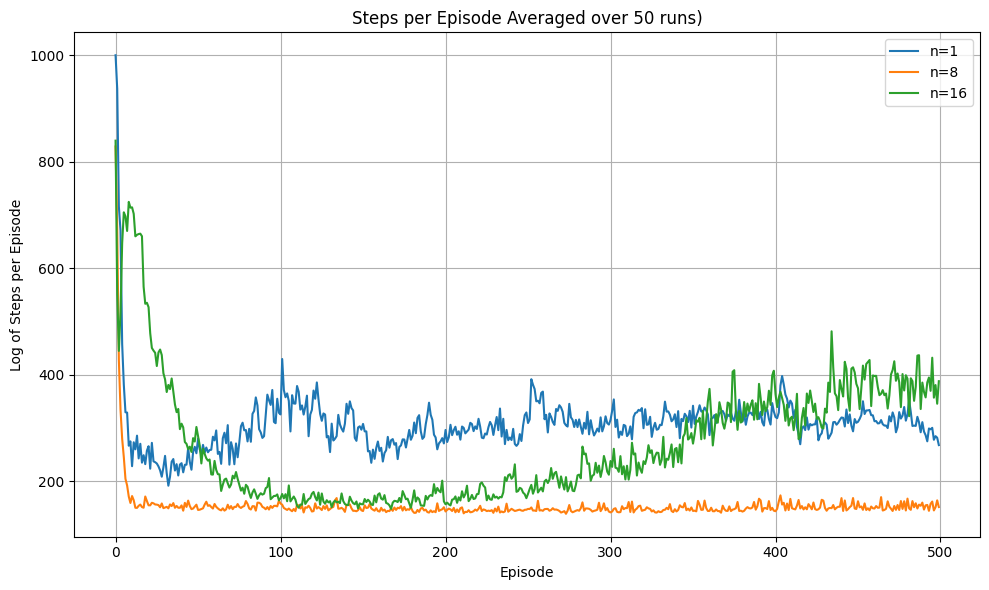

In [14]:
# Your code here
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

def train_for_multiple_n(env_name, order, alpha, gamma, epsilon, num_episodes, n_values, num_runs):

    weights_dict = {}
    avg_steps_dict = {}

    for n in n_values:
        print(f"Training for n={n} over {num_runs} runs...")
        all_steps = np.zeros((num_runs, num_episodes))  

        for run in range(num_runs):
            print(f"Run {run + 1}/{num_runs} for n={n}")
            env = gym.make(env_name)
            steps, _, weights = n_step_semi_gradient_sarsa(env, order, alpha, gamma, epsilon, num_episodes, n)
            all_steps[run] = steps
            if run == num_runs - 1:  
                weights_dict[n] = weights

        avg_steps = np.mean(all_steps, axis=0)
        avg_steps_dict[n] = avg_steps

    return weights_dict, avg_steps_dict

if __name__ == "__main__":
    ENV_NAME = "MountainCar-v0"
    order = 5  
    alpha = 0.01 
    gamma = 0.99  
    epsilon = 0.1  
    num_episodes = 500
    num_runs = 50  
    n_values = [1, 8, 16]  

    weights_dict, avg_steps_dict = train_for_multiple_n(
        ENV_NAME, order, alpha, gamma, epsilon, num_episodes, n_values, num_runs
    )
    
    plt.figure(figsize=(10, 6))
    for n, avg_steps in avg_steps_dict.items():
        plt.plot((avg_steps), label=f"n={n}")

    plt.xlabel("Episode")
    plt.ylabel("Steps per Episode")
    plt.title(f"Steps per Episode Averaged over {num_runs} runs)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


(c) Show an animation of the task for each $n$.

In [18]:
# Your code here


def animate_task(env_name, weights, order, num_actions, n):
    print(f"Animating the task for n={n}...")
    env = gym.make(env_name, render_mode="human")
    env.metadata["render_fps"] = 100

    def evaluate_q_value(state, action, weights, degree):
        features = get_state_value(state, degree)
        return np.dot(weights[:, action], features)

    def select_best_action(state, weights, num_actions, degree):
        q_vals = [evaluate_q_value(state, a, weights, degree) for a in range(num_actions)]
        max_q = np.max(q_vals)
        best_actions = [a for a in range(num_actions) if q_vals[a] == max_q]
        return np.random.choice(best_actions)

    state, _ = env.reset()
    done = False
    total_steps = 0
    total_reward = 0

    while not done:
        action = select_best_action(state, weights, num_actions, order)
        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward
        total_steps += 1
        env.render()
        state = next_state
    print(f"Task Completed for n={n}: Total Steps = {total_steps}, Total Reward = {total_reward}")
    env.close()


if __name__ == "__main__":
    ENV_NAME = "MountainCar-v0"
    order = 5  
    alpha = 0.005
    gamma = 0.99  
    epsilon = 0.1  
    num_episodes = 500
    num_runs = 1  
    n_values = [1, 8, 16]  

    weights_dict, avg_steps_dict = train_for_multiple_n(
        ENV_NAME, order, alpha, gamma, epsilon, num_episodes, n_values, num_runs
    )

    for n in n_values:
        animate_task(ENV_NAME, weights_dict[n], order, gym.make(ENV_NAME).action_space.n, n)


Training for n=1 over 1 runs...
Run 1/1 for n=1
Training for n=8 over 1 runs...
Run 1/1 for n=8
Training for n=16 over 1 runs...
Run 1/1 for n=16
Animating the task for n=1...
Task Completed for n=1: Total Steps = 155, Total Reward = -155.0
Animating the task for n=8...
Task Completed for n=8: Total Steps = 134, Total Reward = -134.0
Animating the task for n=16...
Task Completed for n=16: Total Steps = 140, Total Reward = -140.0


(d) Which value of $n$ results in faster learning? Why?

>Answer

\( n=8 \) learns the fastest among the three as it strikes a balance between low-variance learning and frequent updates, \( n=8 \) learns the fastest. Unlike \( n=1 \), which updates quickly but suffers from high variance, \( n=8 \) offers more stable learning. It also adapts faster than \( n=16 \), which delays updates and takes longer to recognize significant patterns. In the Mountain Car task, where the agent must move away from the goal to gain momentum, \( n=8 \) efficiently captures delayed rewards without overemphasizing short-term gains or slowing updates. This balance makes \( n=8 \) optimal, leading to faster learning and fewer steps per episode.
